### **Importamos paquetes y configuración general**

In [22]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
sns.set_context('talk')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

###  **Leemos los datos**

In [23]:
data_raw = pd.read_csv('./datasets/demanda.csv', parse_dates=True, index_col='TIPO')
data_raw.head()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
TIPO,,,,
2013-01-01,4538446.146,3319300.732,3276372.467,1.113412e+07
2013-02-01,3961686.119,2820263.212,3052210.676,9.834160e+06
2013-03-01,3612835.111,2861328.931,3281965.266,9.756129e+06
2013-04-01,3239380.702,2826797.310,3241156.151,9.307334e+06
2013-05-01,3919668.996,2948663.278,3364493.120,1.023283e+07


Cambiamos la unidad de medida de Watts a mega Watts para que sea más práctico visualizarlo

In [24]:
data = data_raw.copy()
data = data / 1E6

### **Visualización y análisis exploratorio**

Visualizamos las cuatro series temporales utilizando time plots

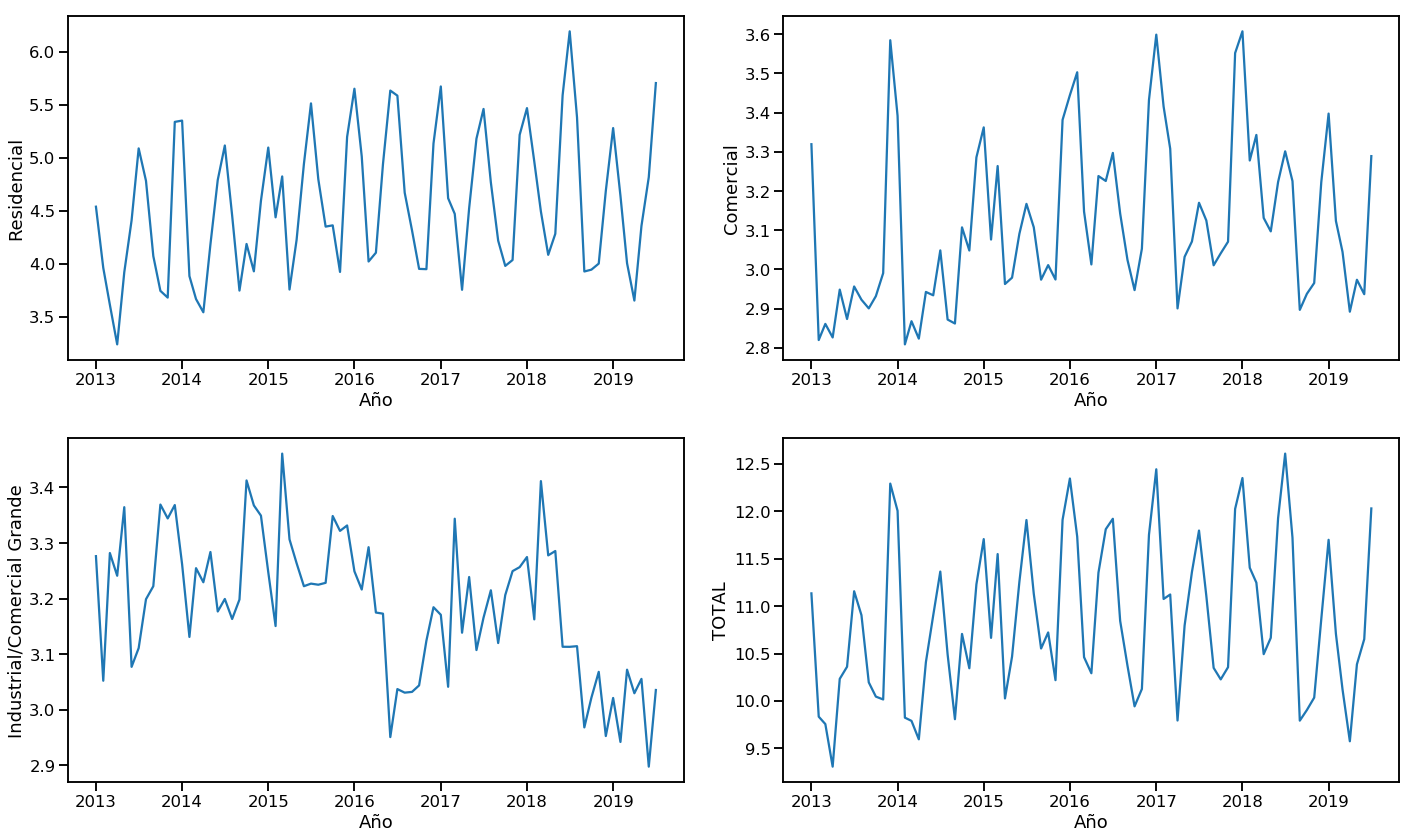

In [25]:
ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

columns = data.columns
for ax, col in zip(axes.flatten(), columns):
    ax.plot(data.index, data[col])
    ax.set_ylabel(col)
    ax.set_xlabel('Año')
plt.tight_layout()
plt.savefig('time_plot.png')
plt.show()

### **Seasonal plots**

Graficamos Seasonal plots cartesiano? y polar para observar cómo cambian las cantidades año a año

In [26]:
data['month'] = data.index.month
data['year'] = data.index.year

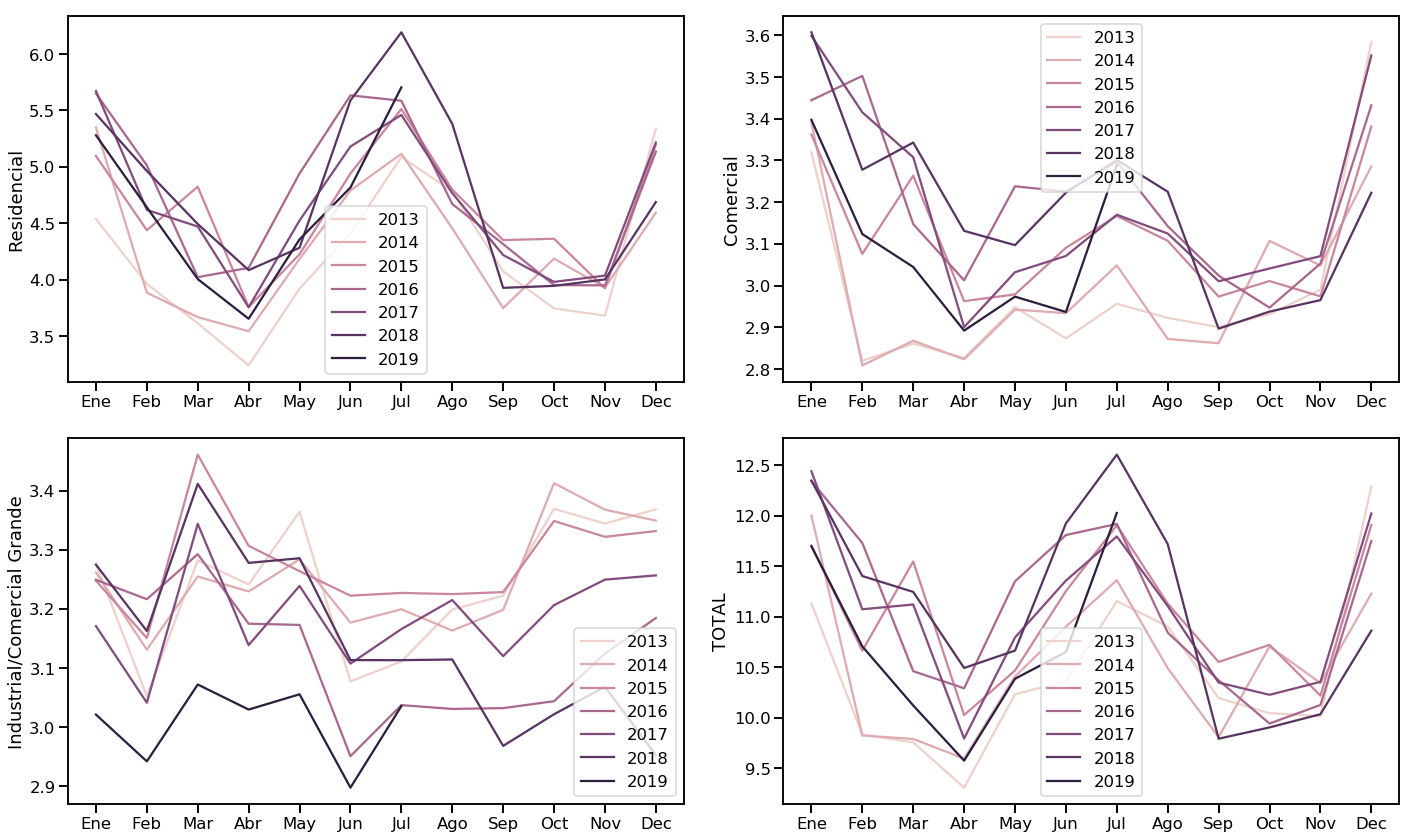

In [27]:
n_colors = data.year.unique().size
palette = sns.cubehelix_palette(n_colors)

ncols = 2
nrows = 2
fig = plt.figure(figsize=(10*ncols, 6*nrows))
axes = []
for i in range(ncols*nrows):
    ax = fig.add_subplot(nrows, ncols, i+1)
    axes.append(ax)

for i, ax in enumerate(axes):
    col = data.columns[i]
    ax.set_xticks(data.month)
    ax.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.set_ylabel(col)
    #ax.set_yticklabels([])
    
for ax, col in zip(axes, columns[:ncols*nrows]):
    for i, year in enumerate(data.year.unique()):
        X = data[data.year==year].month
        Y = data[data.year==year][col]
        ax.plot(X, Y, color=palette[i], label=year)
        ax.legend(loc='best')
        
plt.tight_layout()
plt.savefig('seasonal.png')
plt.show()

#### **Seasonal polar plots**

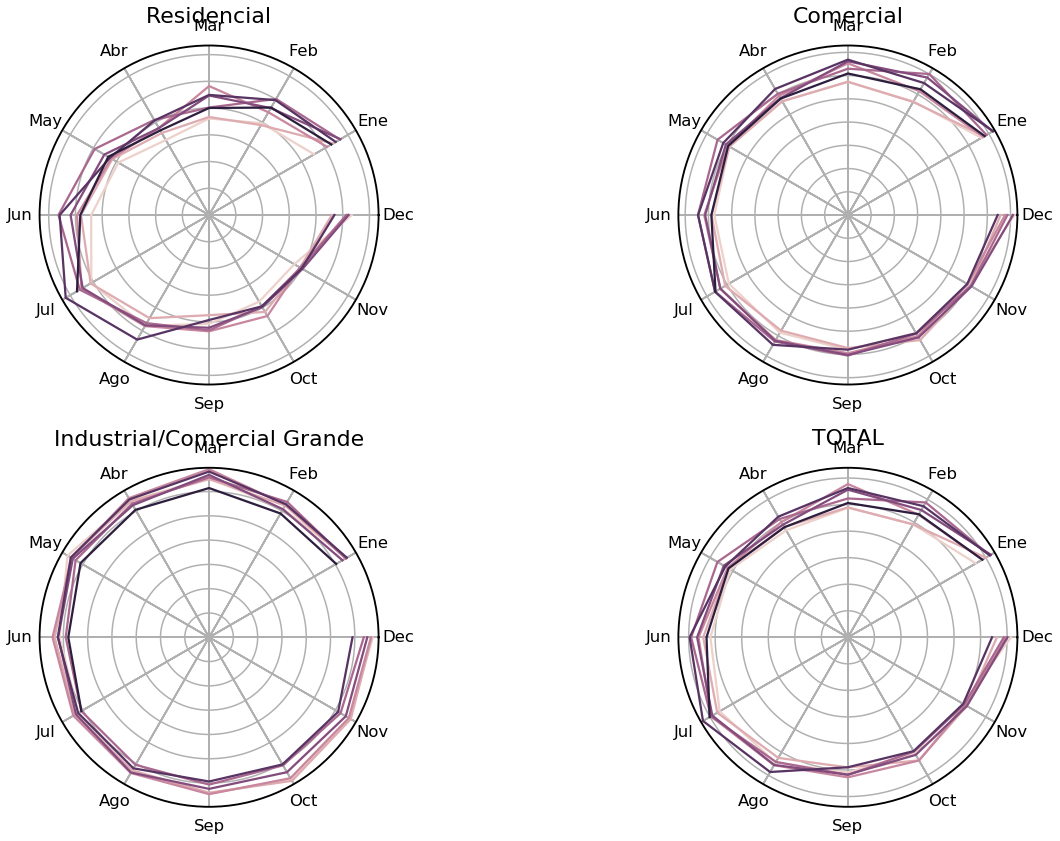

In [28]:
n_colors = data.year.unique().size
palette = sns.cubehelix_palette(n_colors)
years = data.year.unique()

ncols = 2
nrows = 2
fig = plt.figure(figsize=(10*ncols, 6*nrows))
axes = []
for i in range(ncols*nrows):
    ax = fig.add_subplot(nrows, ncols, i+1, projection='polar')
    axes.append(ax)

for i, ax in enumerate(axes):
    col = data.columns[i]
    ax.set_title(col, fontsize=22)
    ax.set_xticks(np.pi*data.month/6)
    ax.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.set_yticklabels([])
    
for ax, col in zip(axes, columns[:ncols*nrows]):
    for i, year in enumerate(years):
        X = (np.pi*data[data.year==year].month/6)
        Y = data[data.year==year][col]
        ax.plot(X, Y, color=palette[i])
plt.tight_layout()
plt.savefig('seasonal_polar.png')
plt.show()

#### **Lag plots**

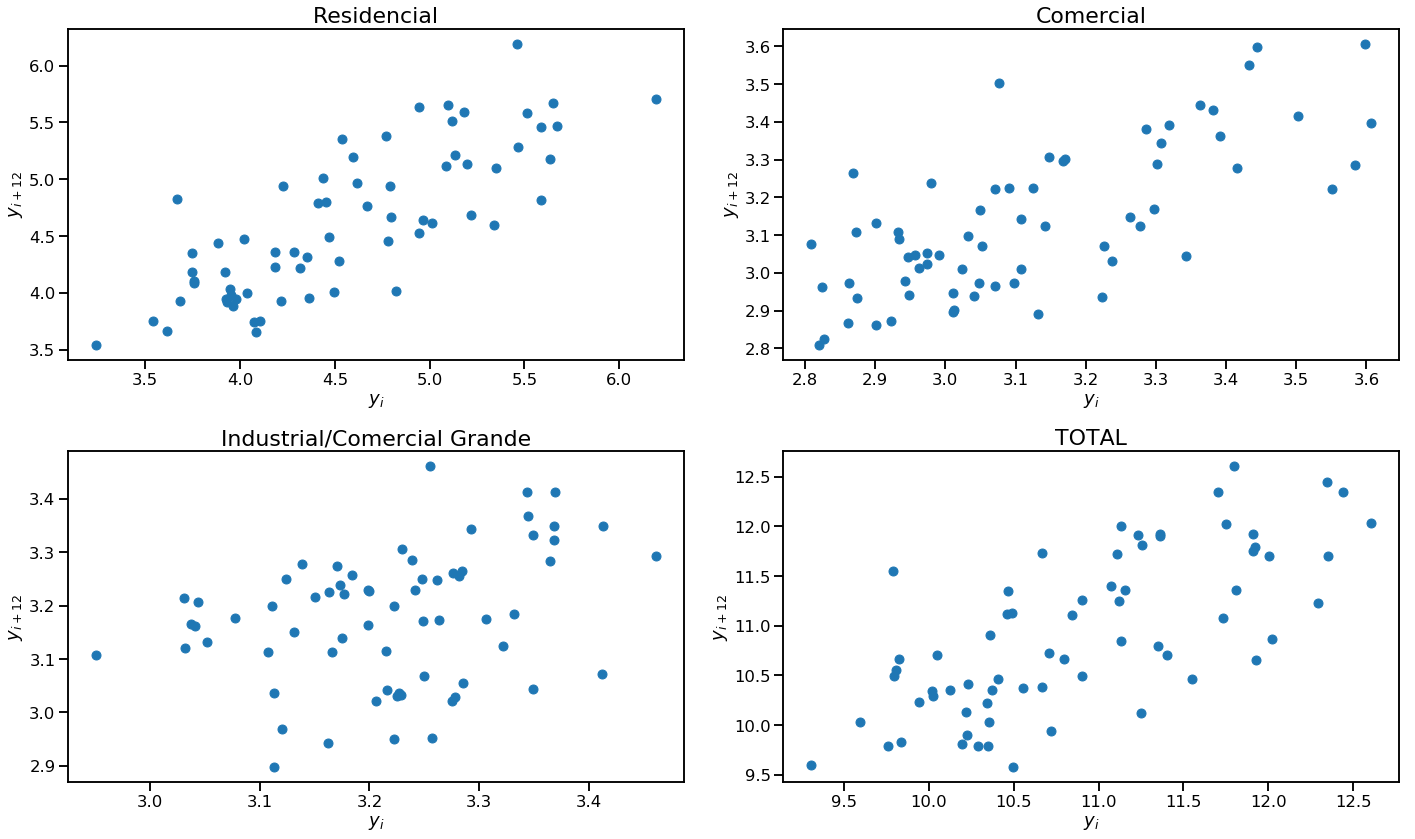

In [29]:
ncols = nrows = 2
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for ax, col in zip(axes.flatten(), data.columns[:4]):
    X = data[col][:-12].values
    Y = data[col][12:].values
    ax.set_xlabel(r'$y_{i}$')
    ax.set_ylabel(r'$y_{i+12}$')
    ax.plot(X, Y, 'o')
    ax.set_title(col, fontsize=22)
plt.tight_layout()
plt.savefig('lag_plot.png')
plt.show()

A simple vista, los lag plots con lag 12 muestran una marcada correlación en la serie correspondiente al consumo residencial, una correlación más dél en el consumo comercial, y poca o nula correlación en el consumo industrial grande. Esto se condice con los seasonal plots, e indica que el consumo energético a nivel domiciliario está fuertemente influenciado por el período del año, y resulta más predecible que el consumo comercial e industrial.

### **Ajuste por calendario**

Dado que disponemos de datos mensuales, resulta conveniente realizar un ajuste por calendario contemplando la cantidad de días en cada mes. En lugar de trabajar con los valores de consumo mensuales, vamos a trabajar con el consumo promedio diario de cada mes. Para eso, necesitamos dividir cada uno de los campos por el número de días de cada mes.

In [30]:
from calendar import monthrange
days_per_month = pd.Series([monthrange(year, month)[1] for (year, month) in zip(data.index.year, data.index.month)],
                           index=data.index)
data = data_raw.copy() #/ days_per_month
data = data.div(days_per_month, axis=0)
data = data / 1E6
data.head()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
TIPO,,,,
2013-01-01,0.146401,0.107074,0.105689,0.359165
2013-02-01,0.141489,0.100724,0.109008,0.351220
2013-03-01,0.116543,0.092301,0.105870,0.314714
2013-04-01,0.107979,0.094227,0.108039,0.310244
2013-05-01,0.126441,0.095118,0.108532,0.330091


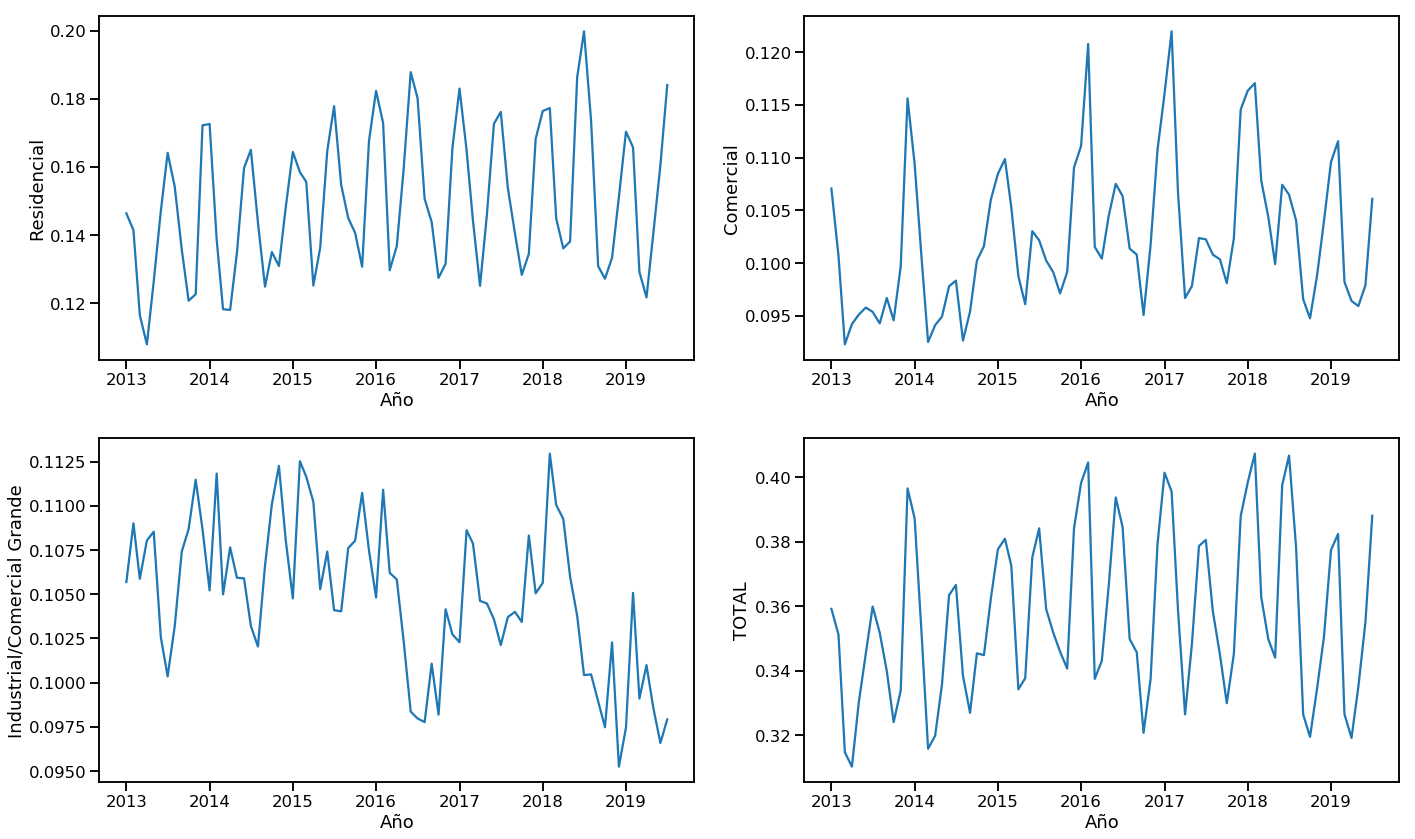

In [31]:
ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

columns = data.columns
for ax, col in zip(axes.flatten(), columns):
    ax.plot(data.index, data[col])
    ax.set_ylabel(col)
    ax.set_xlabel('Año')
plt.tight_layout()
plt.savefig('time_plot_calendar.png')
plt.show()

In [32]:
data['month'] = data.index.month
data['year'] = data.index.year

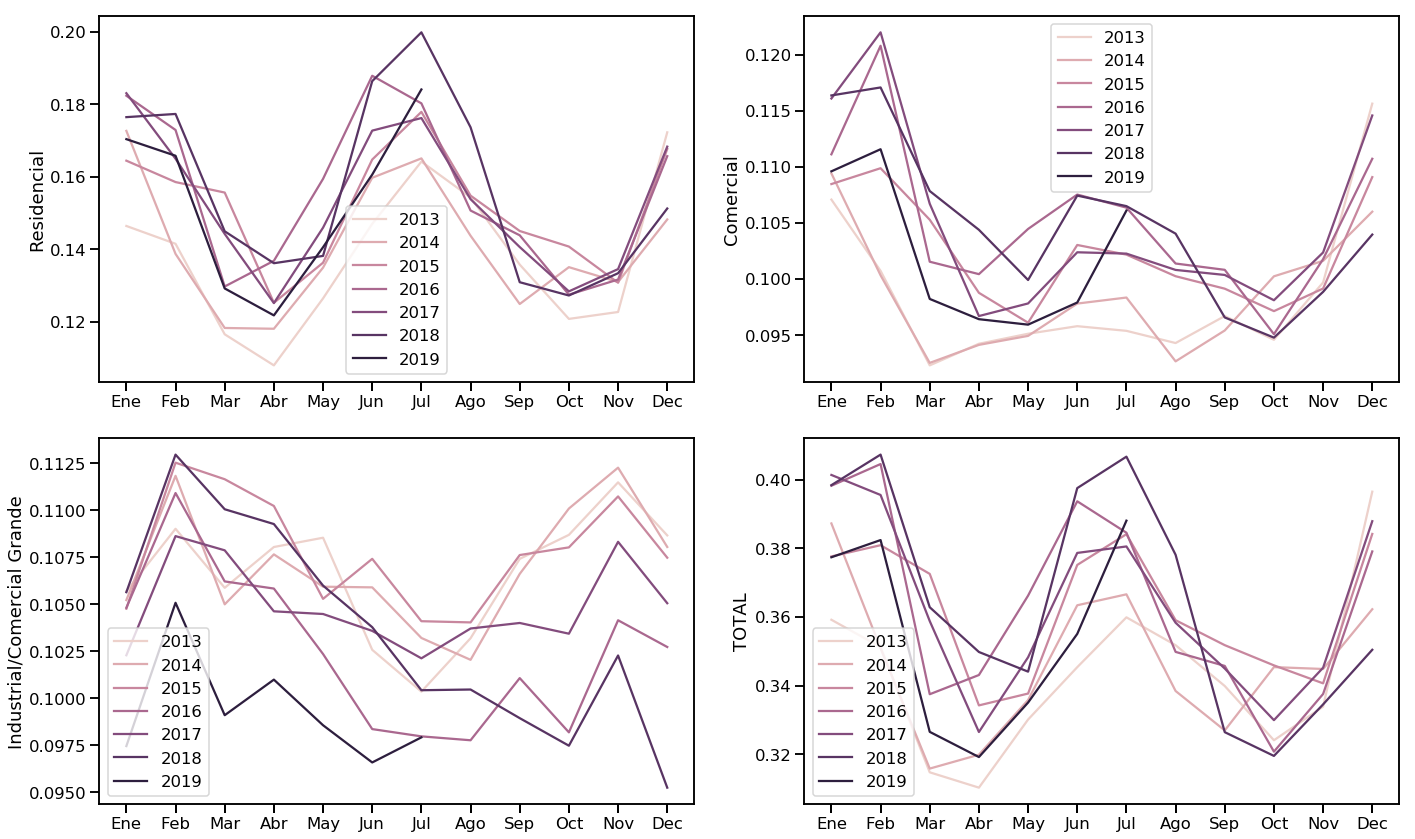

In [33]:
n_colors = data.year.unique().size
palette = sns.cubehelix_palette(n_colors)

ncols = 2
nrows = 2
fig = plt.figure(figsize=(10*ncols, 6*nrows))
axes = []
for i in range(ncols*nrows):
    ax = fig.add_subplot(nrows, ncols, i+1)
    axes.append(ax)

for i, ax in enumerate(axes):
    col = data.columns[i]
    ax.set_xticks(data.month)
    ax.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.set_ylabel(col)
    #ax.set_yticklabels([])
    
for ax, col in zip(axes, columns[:ncols*nrows]):
    for i, year in enumerate(data.year.unique()):
        X = data[data.year==year].month
        Y = data[data.year==year][col]
        ax.plot(X, Y, color=palette[i], label=year)
        ax.legend(loc='best')
        
plt.tight_layout()
plt.savefig('seasonal_calendar.png')
plt.show()

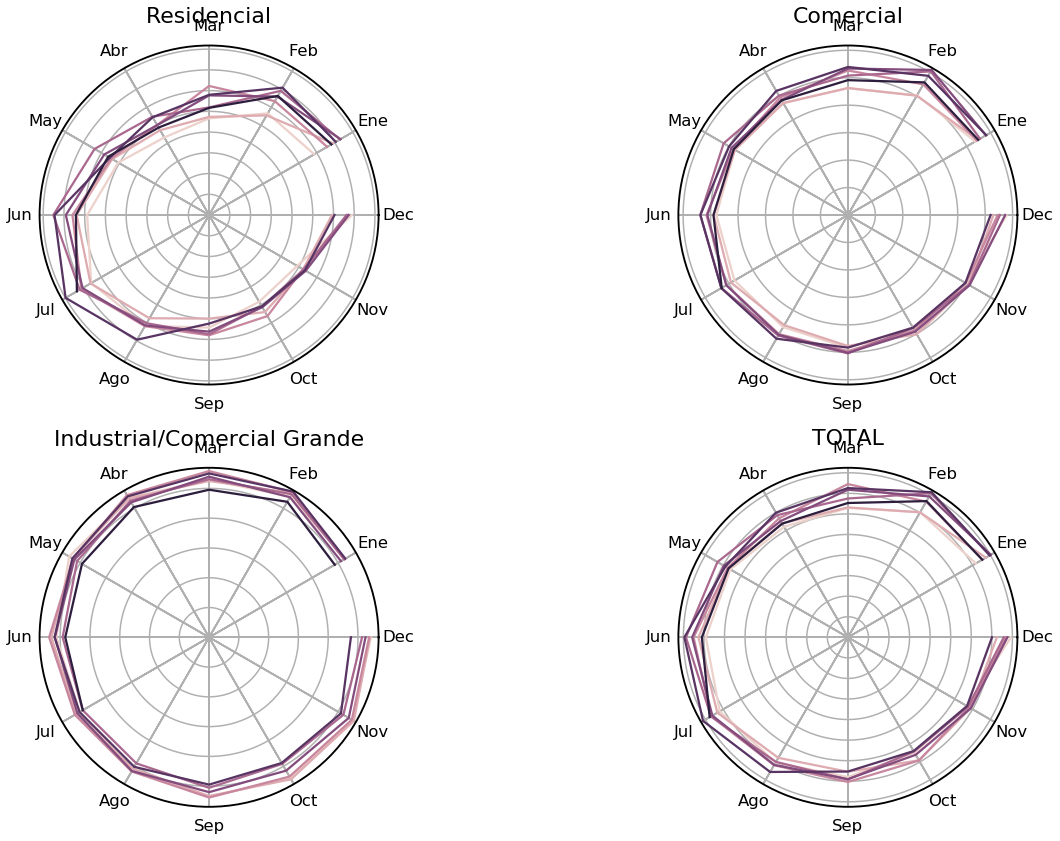

In [34]:
n_colors = data.year.unique().size
palette = sns.cubehelix_palette(n_colors)
years = data.year.unique()

ncols = 2
nrows = 2
fig = plt.figure(figsize=(10*ncols, 6*nrows))
axes = []
for i in range(ncols*nrows):
    ax = fig.add_subplot(nrows, ncols, i+1, projection='polar')
    axes.append(ax)

for i, ax in enumerate(axes):
    col = data.columns[i]
    ax.set_title(col, fontsize=22)
    ax.set_xticks(np.pi*data.month/6)
    ax.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.set_yticklabels([])
    
for ax, col in zip(axes, columns[:ncols*nrows]):
    for i, year in enumerate(years):
        X = (np.pi*data[data.year==year].month/6)
        Y = data[data.year==year][col]
        ax.plot(X, Y, color=palette[i])
plt.tight_layout()
plt.savefig('seasonal_polar_calendar.png')
plt.show()

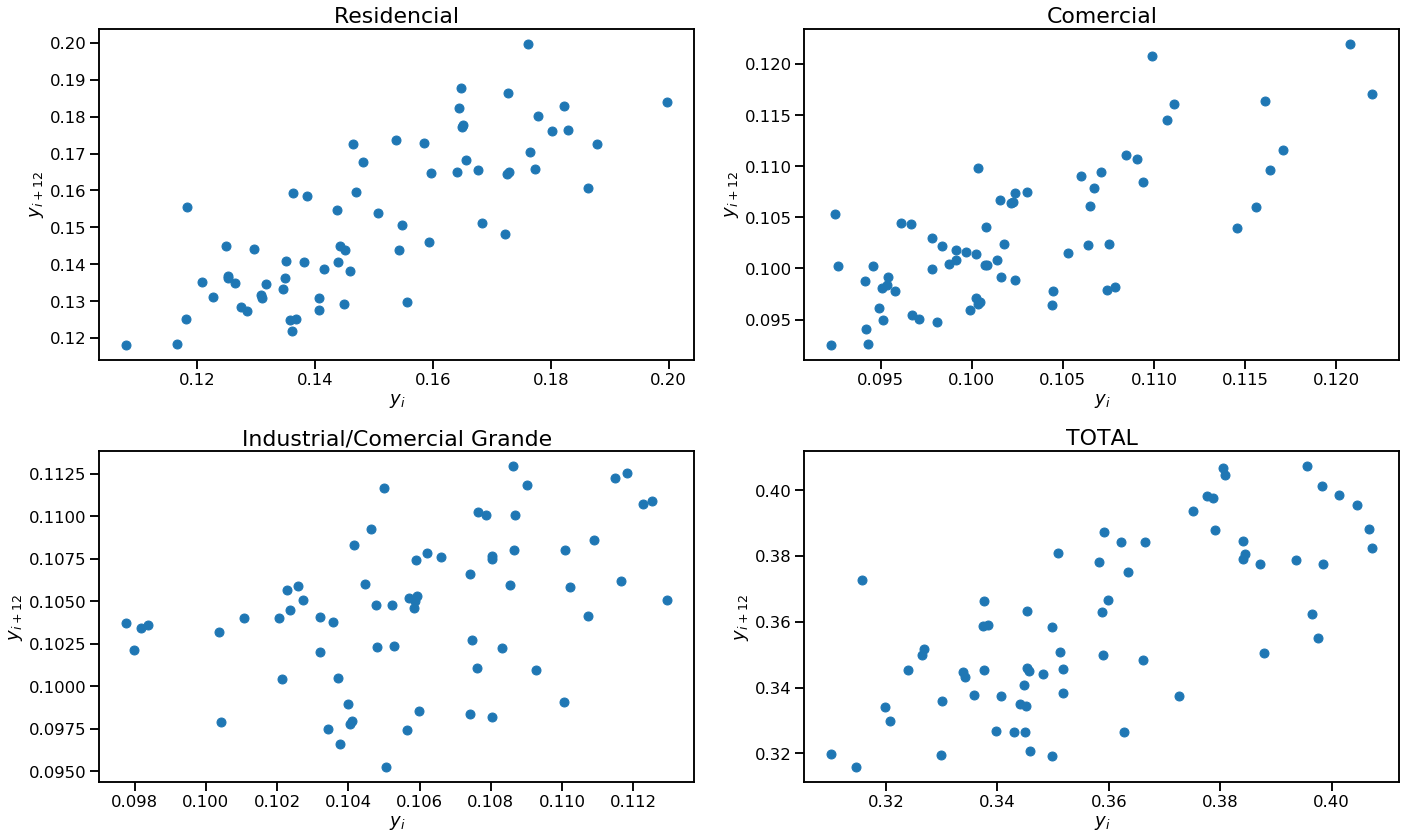

In [35]:
ncols = nrows = 2
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for ax, col in zip(axes.flatten(), data.columns[:4]):
    X = data[col][:-12].values
    Y = data[col][12:].values
    ax.set_xlabel(r'$y_{i}$')
    ax.set_ylabel(r'$y_{i+12}$')
    ax.plot(X, Y, 'o')
    ax.set_title(col, fontsize=22)
    
plt.tight_layout()
plt.savefig('lag_plot_calendar.png')
plt.show()

In [36]:
def hw_summary(model_sm):
    rmse_sm = sm.tools.eval_measures.rmse(model_sm.data.endog,model_sm.fittedvalues)
    print(' In-sample fit:')
    print(' RMSE               {0:.4f}'.format(rmse_sm))
    return model_sm.summary()

## **Holt Winters**

A partir de ahora, seleccionamos sólo una serie temporal para analizar. Elegimos residencial

In [38]:
y = data['Residencial']

### Modelo aditivo

In [40]:
ahw_sm = sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, 
                                     seasonal='add', seasonal_periods=12).fit()

hw_summary(ahw_sm)

 In-sample fit:
 RMSE               0.0084


/home/nahuel/anaconda3/envs/diploDatos/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Dep. Variable:,endog,No. Observations:,79
Model:,ExponentialSmoothing,SSE,0.006
Optimized:,True,AIC,-723.964
Trend:,Additive,BIC,-686.053
Seasonal:,Additive,AICC,-712.564
Seasonal Periods:,12,Date:,"Wed, 09 Oct 2019"
Box-Cox:,False,Time:,19:29:08
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2713340,alpha,True
smoothing_slope,2.3662e-10,beta,True


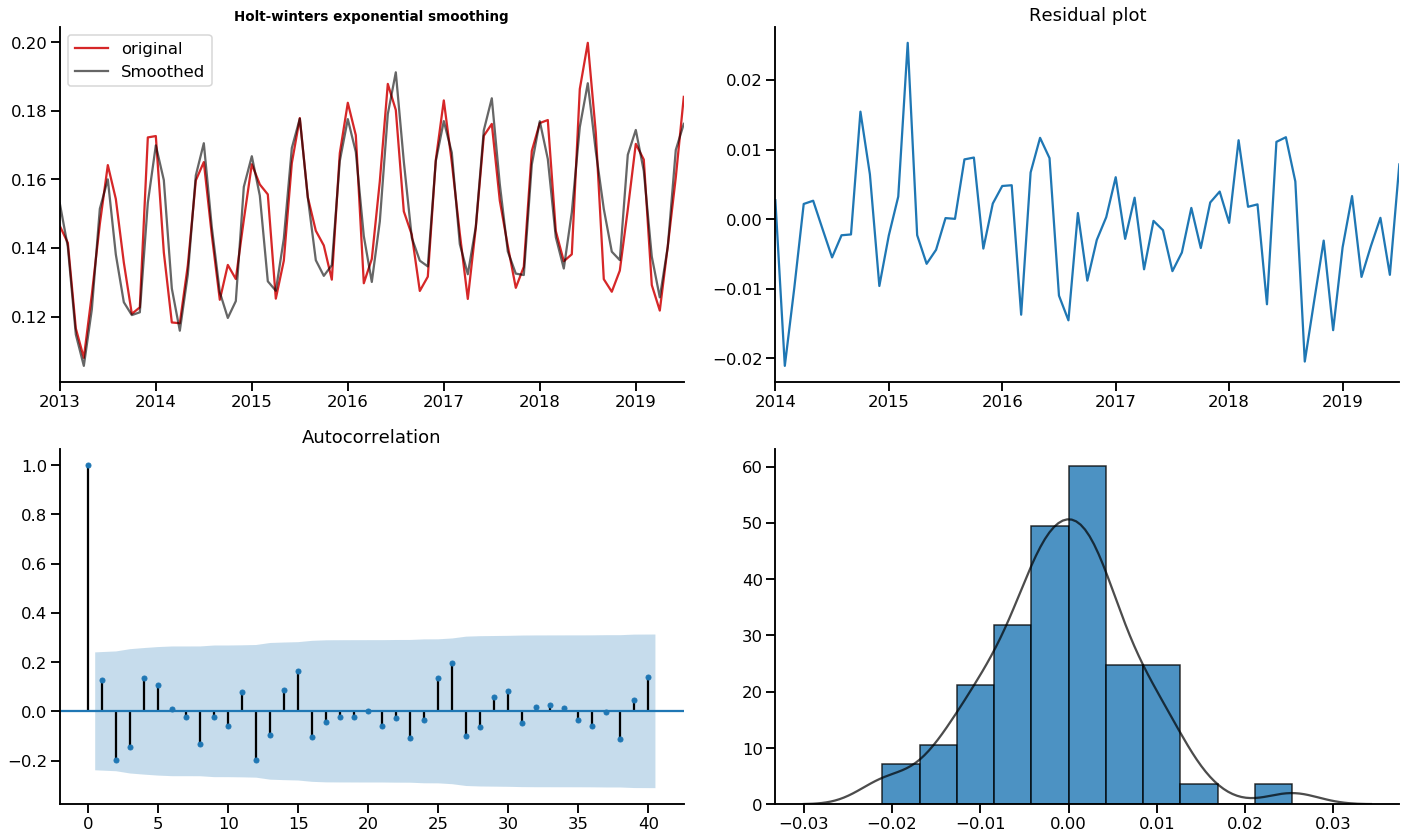

In [41]:
smoothed=pd.Series(ahw_sm.fittedvalues, index=y.index)
resid = (y-ahw_sm.fittedvalues)[12:] # we remove the first 12 observations as they are for initialisitation only


ncols = nrows = 2
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0,0]
y.plot(color='#D62728', ax=ax, label='original')
smoothed.plot(color='black', label='Smoothed', alpha=0.6, ax=ax)
ax.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()

ax = axes[0,1]
resid.plot(ax=ax)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()

ax = axes[1,0]
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()

ax = axes[1,1]
sns.distplot(resid, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': '#1F77B4'},  
             kde_kws={'color': 'black', 'alpha': 0.7})
sns.despine()

plt.tight_layout()
#plt.savefig('lag_plot_calendar.png')
plt.show()


### Modelo multiplicativo

In [46]:
mhw_sm = sm.tsa.ExponentialSmoothing(y, trend='multiplicative', damped=False, 
                                   seasonal='multiplicative', seasonal_periods=12).fit()

hw_summary(mhw_sm)

 In-sample fit:
 RMSE               0.0081


/home/nahuel/anaconda3/envs/diploDatos/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Dep. Variable:,endog,No. Observations:,79
Model:,ExponentialSmoothing,SSE,0.005
Optimized:,True,AIC,-728.426
Trend:,Multiplicative,BIC,-690.515
Seasonal:,Multiplicative,AICC,-717.026
Seasonal Periods:,12,Date:,"Wed, 09 Oct 2019"
Box-Cox:,False,Time:,19:30:20
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2629147,alpha,True
smoothing_slope,2.7136e-07,beta,True


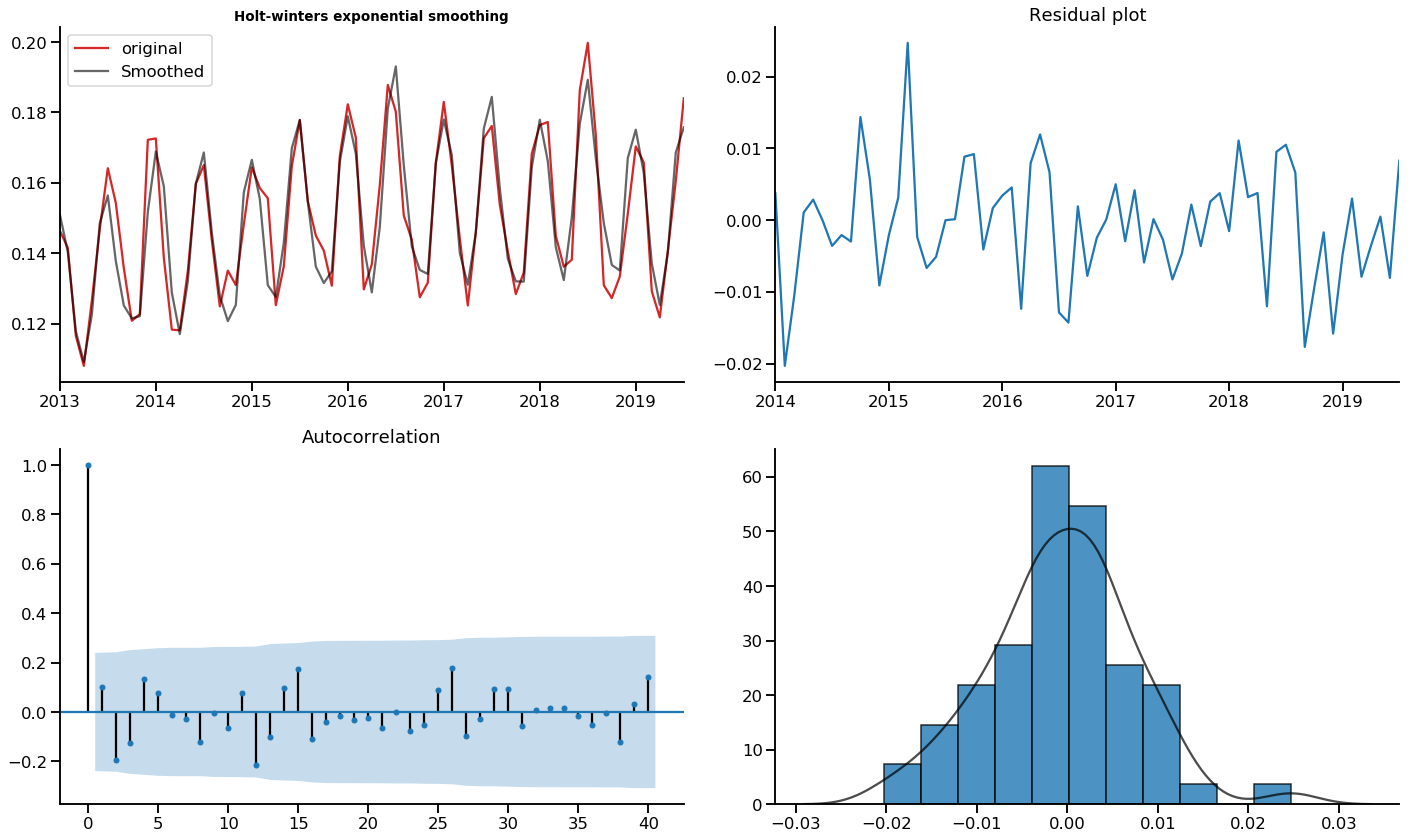

In [47]:
smoothed=pd.Series(mhw_sm.fittedvalues, index=y.index)
resid = (y-mhw_sm.fittedvalues)[12:] # we remove the first 12 observations as they are for initialisitation only


ncols = nrows = 2
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0,0]
y.plot(color='#D62728', ax=ax, label='original')
smoothed.plot(color='black', label='Smoothed', alpha=0.6, ax=ax)
ax.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()

ax = axes[0,1]
resid.plot(ax=ax)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()

ax = axes[1,0]
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()

ax = axes[1,1]
sns.distplot(resid, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': '#1F77B4'},  
             kde_kws={'color': 'black', 'alpha': 0.7})
sns.despine()

plt.tight_layout()
#plt.savefig('lag_plot_calendar.png')
plt.show()

Tanto visualmente como por su error cuadrático medio, ambos modelos (multiplicativo y aditivo) presentan características similares. En ambos casos la autocorrelación no es significativa y los residuos se distribuyen en torno a cero, con una distribución unimodal similar a una gaussiana.

Para hacer un análisis más cuidadoso procedemos a separar el conjunto de datos en entrenamiento y test, y evaluamos distintos parámetros

In [48]:
train = y[y.index.year < 2018]
test = y[y.index.year == 2018]

In [49]:
import warnings
warnings.simplefilter('ignore')

errors = []

print('Trend\t\tSeasonal\tDamped\tRMSE', end='\n\n')
for trend in ['additive', 'multiplicative']:
    for seasonal in ['additive', 'multiplicative']:
        for damped in [False, True]:
            model_sm=sm.tsa.ExponentialSmoothing(train, trend=trend, damped=damped, 
                                                 seasonal=seasonal, seasonal_periods=12).fit()
            rmse_sm = sm.tools.eval_measures.rmse(model_sm.data.endog,model_sm.fittedvalues)
            #print('{:s}\t{:s}\t{}\t{0:.4f}'.format(trend, seasonal, damped, rmse_sm))
            info = [trend, seasonal, damped, rmse_sm]
            print('{}\t{}\t{}\t{:.4f}'.format(*info))
            errors.append(info)
            
warnings.simplefilter('default')

Trend		Seasonal	Damped	RMSE

additive	additive	False	0.0077
additive	additive	True	0.0073
additive	multiplicative	False	0.0076
additive	multiplicative	True	0.0073
multiplicative	additive	False	0.0077
multiplicative	additive	True	0.0098
multiplicative	multiplicative	False	0.0076
multiplicative	multiplicative	True	0.0073


Observamos cuál es el modelo con menor error

In [52]:
sorted(errors, key=lambda x: x[3])[0]

['multiplicative', 'multiplicative', True, 0.0072796403298135024]

In [53]:
model_sm=sm.tsa.ExponentialSmoothing(y, trend='multiplicative', damped=True, \
                                     seasonal='multiplicative', seasonal_periods=12).fit()

/home/nahuel/anaconda3/envs/diploDatos/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


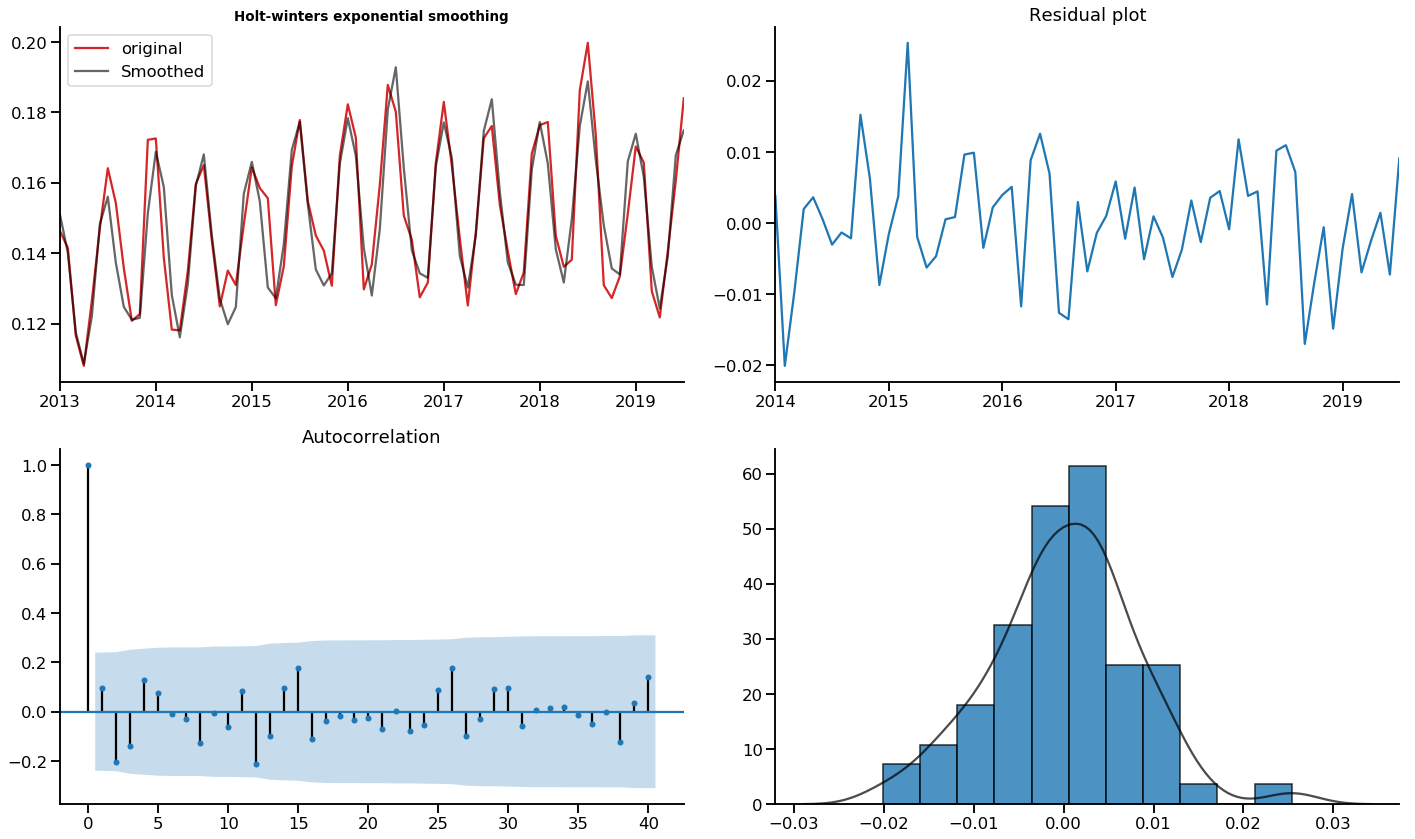

In [54]:
smoothed=pd.Series(model_sm.fittedvalues, index=y.index)
resid = (y-model_sm.fittedvalues)[12:] # we remove the first 12 observations as they are for initialisitation only


ncols = nrows = 2
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0,0]
y.plot(color='#D62728', ax=ax, label='original')
smoothed.plot(color='black', label='Smoothed', alpha=0.6, ax=ax)
ax.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()

ax = axes[0,1]
resid.plot(ax=ax)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()

ax = axes[1,0]
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()

ax = axes[1,1]
sns.distplot(resid, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': '#1F77B4'},  
             kde_kws={'color': 'black', 'alpha': 0.7})
sns.despine()

plt.tight_layout()
#plt.savefig('lag_plot_calendar.png')
plt.show()

Realizamos una predicción de dos períodos completos para este modelo

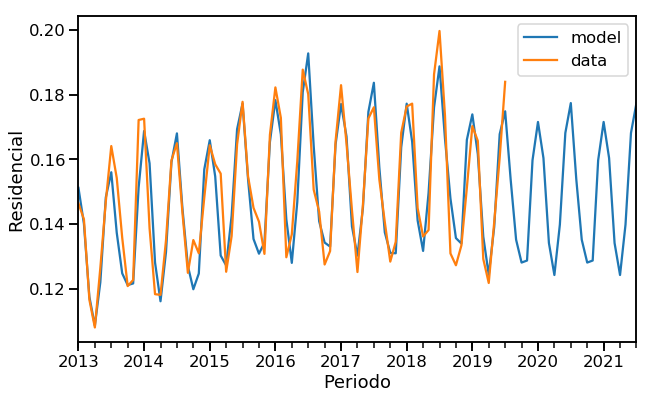

In [57]:
h = 2*12
plot = pd.DataFrame()
plot['model'] = pd.concat([model_sm.fittedvalues, model_sm.forecast(h)])
plot['data'] = y
fig, ax = plt.subplots(figsize=(10, 6))
plot.plot(ax=ax)
ax.set_xlabel('Periodo')
ax.set_ylabel('Residencial')
plt.show()